<h1>Chroma-based audio alignment</h1>
Based on resources from the text book "Fundamentals of Music Processing". The chroma computation used in the week 6 tutorial is repeated here, with other helper functions. These are included in case you don't have FMPLib installed, so that this notebook can run independently.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
from scipy import signal
%matplotlib inline

In [2]:
def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)', title='',
                dpi=72, colorbar=True, colorbar_aspect=20.0, ax=None, figsize=(6, 3), **kwargs):
    """Plot a matrix, e.g. a spectrogram or a tempogram

    From notebook: B/B_PythonVisualization.ipynb

    Args:
        X: The matrix
        Fs: Sample rate for axis 1
        Fs_F: Sample rate for axis 0
        T_coef: Time coeffients. If None, will be computed, based on Fs.
        F_coef: Frequency coeffients. If None, will be computed, based on Fs_F.
        xlabel: Label for x axis
        ylabel: Label for y axis
        title: Title for plot
        dpi: Dots per inch
        colorbar: Create a colorbar.
        colorbar_aspect: Aspect used for colorbar, in case only a single axes is used.
        ax: Either (1.) a list of two axes (first used for matrix, second for colorbar), or (2.) a list with a single
            axes (used for matrix), or (3.) None (an axes will be created).
        figsize: Width, height in inches
        **kwargs: Keyword arguments for matplotlib.pyplot.imshow

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        plt.colorbar(im, cax=ax[1])
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        plt.colorbar(im, aspect=colorbar_aspect)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im

In [3]:
def smooth_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10, w_type='boxcar'):
    """Smoothes and downsamples a feature sequence. Smoothing is achieved by convolution with a filter kernel

    Notebook: C3/C3S1_FeatureSmoothing.ipynb

    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
    """
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

def median_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10):
    """Smoothes and downsamples a feature sequence. Smoothing is achieved by median filtering

    Notebook: C3/C3S1_FeatureSmoothing.ipynb

    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
    """
    assert filt_len % 2 == 1  # L needs to be odd
    filt_len = [1, filt_len]
    X_smooth = signal.medfilt2d(X, filt_len)
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

def filter_diag_SM(S, L):
    """Path smoothing of similarity matrix by forward filtering along main diagonal

    Notebook: C4/C4S2_SSM-PathEnhancement.ipynb

    Args:
        S: Similarity matrix (SM)
        L: Length of filter 

    Returns:
        S_L: Smoothed SM
    """
    N = S.shape[0]
    M = S.shape[1]
    S_L = np.zeros((M,N))
    S_extend_L = np.zeros((N + L, M + L))
    S_extend_L[0:M,0:N] = S
    for pos in range(0,L):
        S_L = S_L + S_extend_L[pos:(M + pos), pos:(N + pos)]
    S_L = S_L/L
    return S_L

def median_filter_diag_SM(S, L):
    """Path smoothing of similarity matrix by symmetric median filtering along main diagonal.

    Args:
        S: Similarity matrix (SM)
        L: Half-length of filter (i.e. filter is length 2L-1)

    Returns:
        S_L: Smoothed SM
    """
    N = S.shape[0]
    M = S.shape[1]
    sz = 2 * L - 1;
    S_extend_L = np.zeros((sz, N+sz, M+sz))
    for pos in range(sz):
        S_extend_L[pos, pos:N+pos, pos:M+pos] = S
    S_L = np.median(S_extend_L, axis=0)
    S_L = S_L[L-1:N+L-1, L-1:M+L-1]
    return S_L

<h2>Compute chroma-based self-similarity matrix</h2>

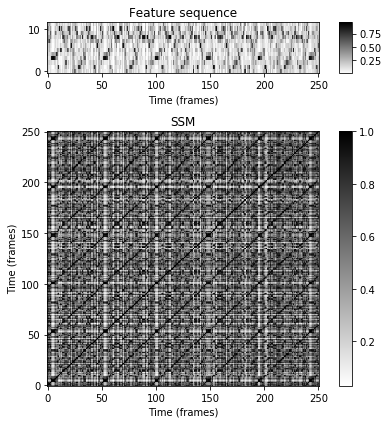

In [4]:
# load wav file
x, Fs = librosa.load('Chameleon60-85.wav', sr=22050)
ipd.display(ipd.Audio(x, rate=Fs))

# Compute chromagram with default features
N = 4096         # FFT size
H = Fs // 10     # Hop size = 0.1s
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2,
                                hop_length=H, n_fft=N)
#C, Fs_C = smooth_downsample_feature_sequence(C, Fs/H, filt_len=5,
#                                             down_sampling=2)
#C, Fs_C = median_downsample_feature_sequence(C, Fs/H, filt_len=5,
#                                             down_sampling=2)

# Compute self-similarity matrix
S = np.dot(np.transpose(C),C)

cmap = 'gray_r'
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [0.2, 1]}, figsize=(5.5, 6))
plot_matrix(C, Fs=1, ax=[ax[0,0], ax[0,1]], cmap=cmap,
            xlabel='Time (frames)', ylabel='', title='Feature sequence')
plot_matrix(S, Fs=1, ax=[ax[1,0], ax[1,1]], cmap=cmap,
            title='SSM', xlabel='Time (frames)', ylabel='Time (frames)', colorbar=True)
plt.tight_layout()

#plt.savefig('SSM-Chameleon.pdf')

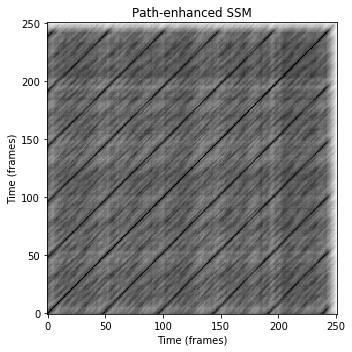

In [12]:
# Path enhancement by filtering along the diagonal
S_enhanced1 = filter_diag_SM(S, 10)
plot_matrix(S_enhanced1, Fs=1, cmap=cmap, figsize=(5, 5), 
            title='Path-enhanced SSM', colorbar = False,
            xlabel='Time (frames)', ylabel='Time (frames)')
plt.tight_layout()

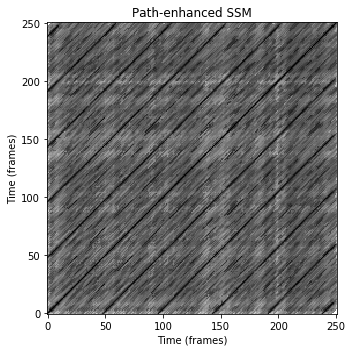

In [13]:
# Path enhancement by median-filtering along the diagonal
S_enhanced2 = median_filter_diag_SM(S, 5)
plot_matrix(S_enhanced2, Fs=1, cmap=cmap, figsize=(5, 5), 
            title='Path-enhanced SSM', colorbar = False,
            xlabel='Time (frames)', ylabel='Time (frames)')
plt.tight_layout()

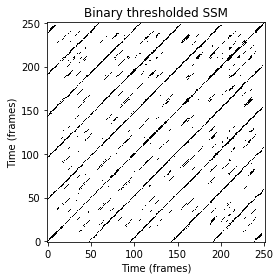

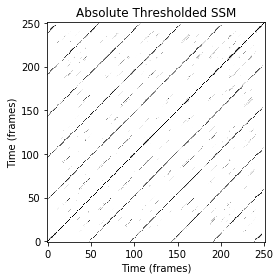

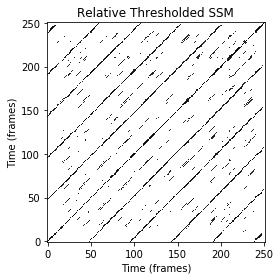

In [14]:
# Binary thresholding
T = 0.8
S_binary_threshold = (S_enhanced2 >= T)
plot_matrix(S_binary_threshold, Fs=1, figsize=(4, 4), cmap=cmap,
            title='Binary thresholded SSM', colorbar = False,
            xlabel='Time (frames)', ylabel='Time (frames)')

# Thresholding and scaling
S_abs_threshold = np.maximum(S_enhanced2 - T, 0)
S_abs_threshold /= np.max(np.max(S_abs_threshold))
plot_matrix(S_abs_threshold, Fs=1, figsize=(4, 4), cmap=cmap,  
            title='Absolute Thresholded SSM', colorbar = False,
            xlabel='Time (frames)', ylabel='Time (frames)')

# Relative thresholding
T_rel = np.quantile(S_enhanced2, 0.95)
S_rel_threshold = (S_enhanced2 >= T_rel) * S_enhanced2
plot_matrix(S_rel_threshold, Fs=1, figsize=(4, 4), cmap=cmap,
            title='Relative Thresholded SSM', colorbar = False,
            xlabel='Time (frames)', ylabel='Time (frames)');

Exercise: How would you find the high-scoring paths?